# CNN model on distributions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../src/")
from collections import OrderedDict
import cellbell

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import utils

from models import Conv1DDistribution
from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split

Using Theano backend.
Using gpu device 0: GeForce GT 630M (CNMeM is disabled, cuDNN not available)


In [3]:
data_file = "../data/processed/ensemble-data.h5"
df = pd.read_hdf(data_file, "predictions")
actual = pd.read_hdf(data_file, "actual")

## Mix models for predicting week 1

In [4]:
subset = df[df["variable"].str.contains("ph_1_inc_bin")]

In [5]:
subset = subset.pivot_table(index=["model", "region", "time"], columns=["variable"], values=["value"])
subset = subset.reset_index()

In [6]:
kde = subset[subset["model"] == "kde"]
sarima = subset[subset["model"] == "sarima"]
kcde = subset[subset["model"] == "kcde"]

In [7]:
# Common time, region identifier to work on
kde_times = kde["time"].astype("str") + "-" + kde["region"]
sarima_times = sarima["time"].astype("str") + "-" + sarima["region"]
kcde_times = kcde["time"].astype("str") + "-" + kcde["region"]
p_times = pd.Series(list(set(kde_times).intersection(set(sarima_times).intersection(set(kcde_times)))))

one_wk_times = (p_times.str.split("-").str[0].map(int) + 1).astype("str") + "-" + p_times.str.split("-").str[1]

# Skip entries that are not in actual_times after +1 
actual_times = actual["time"].astype("str") + "-" + actual["region"]
p_times = p_times[one_wk_times.isin(actual_times)]

In [8]:
kde = kde[kde_times.isin(p_times)]
sarima = sarima[sarima_times.isin(p_times)]
kcde = kcde[kcde_times.isin(p_times)]
assert kde.shape == sarima.shape == kcde.shape

In [9]:
y = np.zeros_like(p_times)
X_kde = np.zeros_like(kde["value"])
X_sarima = np.zeros_like(sarima["value"])
X_kcde = np.zeros_like(kcde["value"])

for idx, ct in enumerate(p_times):
    time, region = ct.split("-")
    time = int(time)
    
    X_kde[idx, :] = kde[(kde["region"] == region) & (kde["time"] == time)]["value"].as_matrix()
    X_sarima[idx, :] = sarima[(sarima["region"] == region) & (sarima["time"] == time)]["value"].as_matrix()
    X_kcde[idx, :] = kcde[(kcde["region"] == region) & (kcde["time"] == time)]["value"].as_matrix()
    
    y[idx] = actual["actual"].as_matrix()[(actual["region"] == region) & (actual["time"] == time + 1)][0]

In [11]:
# reorder X
n_bins = 131 # from 0 to 13 in steps of 0.1
bins = np.linspace(0, 13, num=n_bins)
real_bin_order = ["ph_1_inc_bin_{0:g}_log_prob".format(b) for b in bins]

In [18]:
real_bin_order_indices = [subset["value"].columns.tolist().index(i) for i in real_bin_order]
X_kde = X_kde[:, real_bin_order_indices]
X_sarima = X_sarima[:, real_bin_order_indices]
X_kcde = X_kcde[:, real_bin_order_indices]

### Convert y to categories

In [19]:
n_bins = 131 # from 0 to 13 in steps of 0.1
bins = np.linspace(0, 13, num=n_bins)

Y = np.zeros((len(y), n_bins))

In [20]:
for i in range(len(y)):
    index = np.sum(y[i] > bins) - 1
    Y[i, index] = 1

In [21]:
X = np.exp(np.stack([X_kde, X_sarima, X_kcde], axis=-1))

In [22]:
X_week = p_times.str.split("-").str[0].map(int) % 100

### Training

In [24]:
X_train, X_test, X_week_train, X_week_test, Y_train, Y_test = train_test_split(X, X_week, Y, test_size=0.2)

In [65]:
model = Conv1DDistribution(3, n_bins, 30)

In [66]:
model.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_15 (Convolution1D) (None, 131, 64)       1024                                         
____________________________________________________________________________________________________
convolution1d_16 (Convolution1D) (None, 131, 20)       6420                                         
____________________________________________________________________________________________________
flatten_15 (Flatten)             (None, 2620)          0                                            
____________________________________________________________________________________________________
dense_29 (Dense)                 (None, 30)            78630                                        
___________________________________________________________________________________________

In [67]:
history = model.fit([X_train, X_week_train], Y_train,
                    batch_size=32, nb_epoch=15,
                    verbose=0, callbacks=[TQDMNotebookCallback()],
                    validation_split=0.2,
                    shuffle=True)

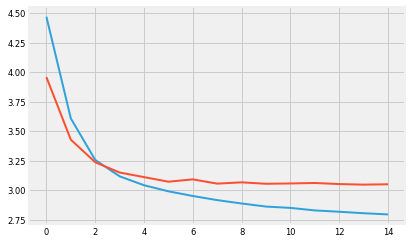

In [68]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [69]:
out = model.predict([X_test, X_week_test])

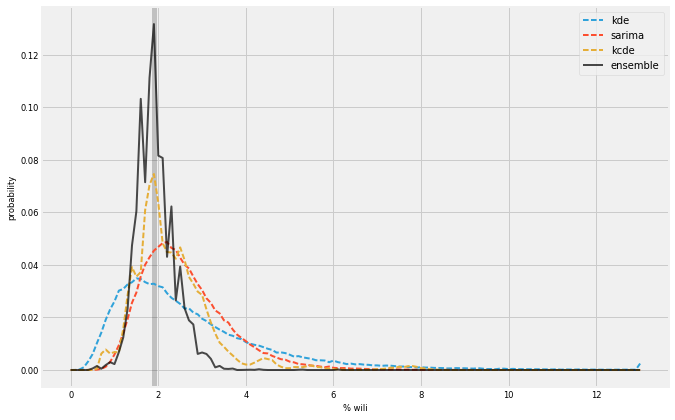

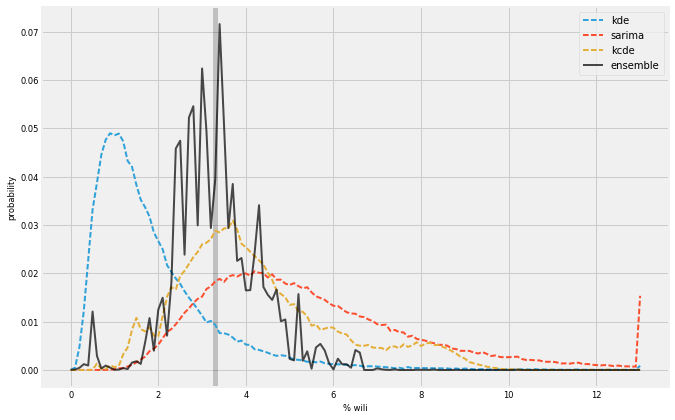

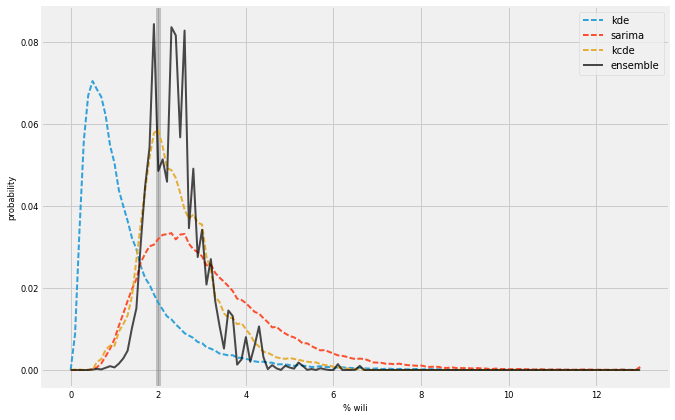

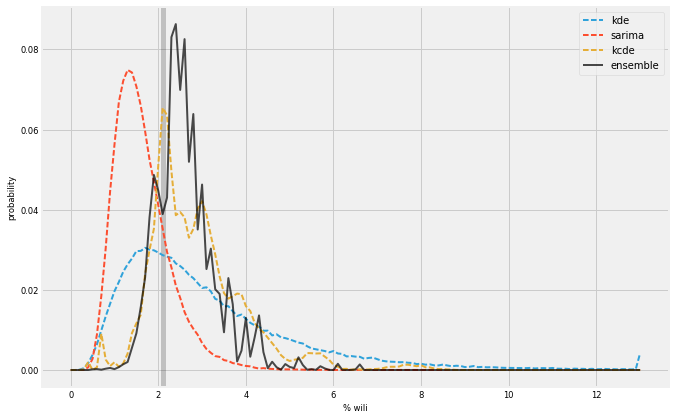

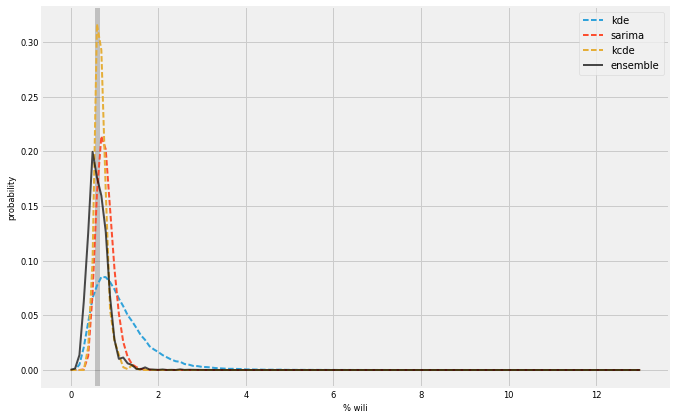

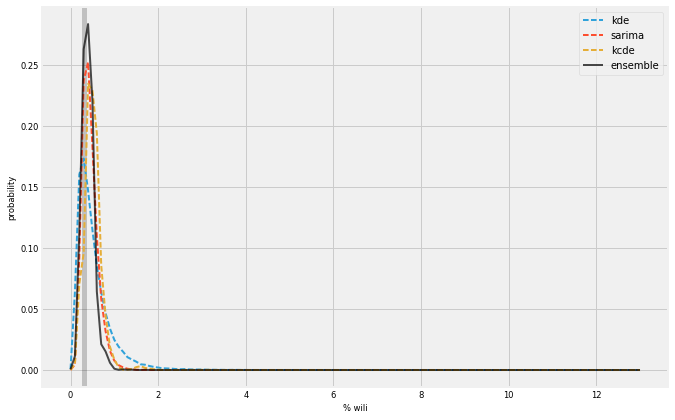

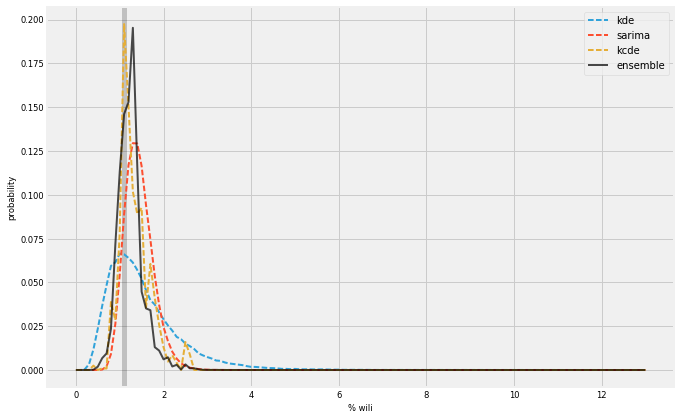

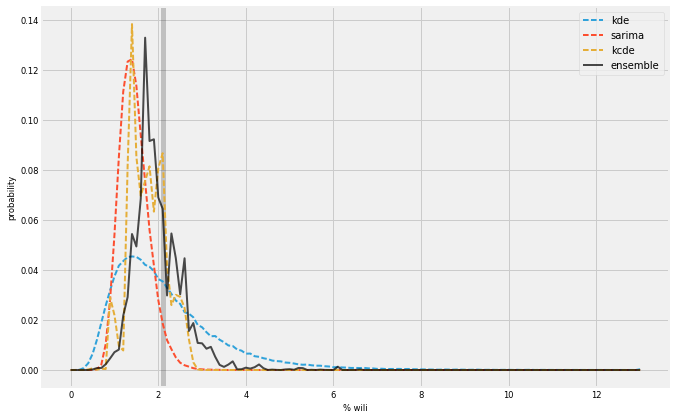

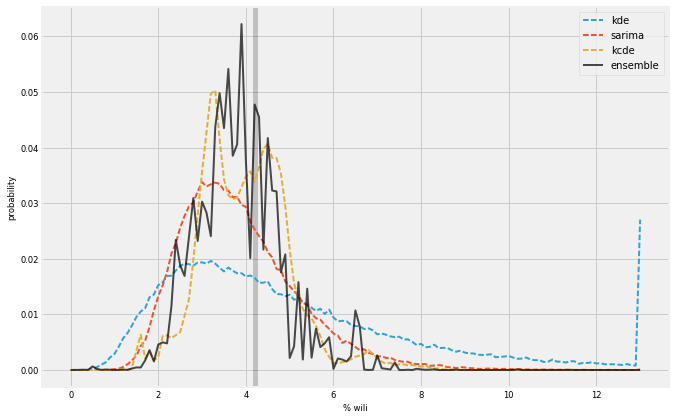

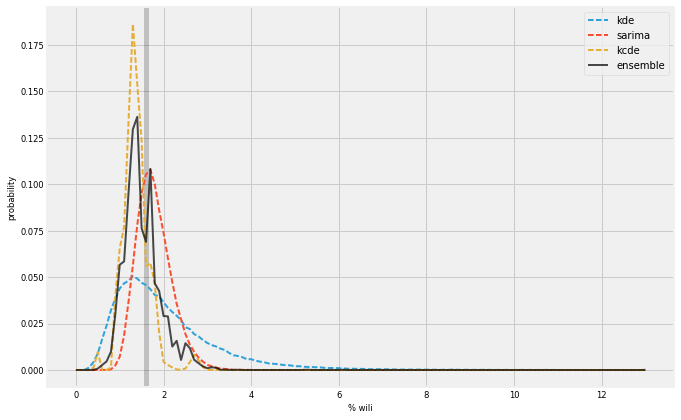

In [72]:
for i in range(10):
    index = np.random.randint(0, len(out))
    plt.figure(figsize=(10, 7))
    plt.axvline(x=bins[np.where(Y_test[index] == 1)[0][0]], linewidth=5, color="k", alpha=0.2)
    plt.plot(bins, X_test[index][:, 0], linestyle="--", label="kde")
    plt.plot(bins, X_test[index][:, 1], linestyle="--", label="sarima")
    plt.plot(bins, X_test[index][:, 2], linestyle="--", label="kcde")
    plt.plot(bins, out[index], color="k", alpha=0.7, label="ensemble")
    plt.xlabel("% wili")
    plt.ylabel("probability")
    plt.legend()

In [70]:
# print losses
print("Crossentropy losses\n")
print("kde:", utils.prediction_score(Y_test, X_test[:, :, 0]).eval().mean())
print("sarima:", utils.prediction_score(Y_test, X_test[:, :, 1]).eval().mean())
print("kcde:", utils.prediction_score(Y_test, X_test[:, :, 2]).eval().mean())
print("ensemble:", utils.prediction_score(Y_test, out).eval().mean())

Crossentropy losses

kde: 3.6130509292
sarima: 3.02611995792
kcde: 2.9385678767
ensemble: 2.85840831438
